In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pandas as pd

In [ ]:
# Check for GPU availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        strategy = tf.distribute.MirroredStrategy()
        print("Using GPU!")
    except RuntimeError as e:
        print(e)
else:
    strategy = tf.distribute.get_strategy()
    print("No GPU found, using CPU.")

Using GPU!


In [3]:
# Paths and Parameters
train_dir = '/content/drive/MyDrive/cats_and_dogs_filtered/train'
validation_dir = '/content/drive/MyDrive/cats_and_dogs_filtered/validation'
img_height, img_width = 224, 224
batch_size = 32
epochs = 5

In [4]:
# Data Generators
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
train_gen = train_datagen.flow_from_directory(train_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='binary')
val_gen = val_datagen.flow_from_directory(validation_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


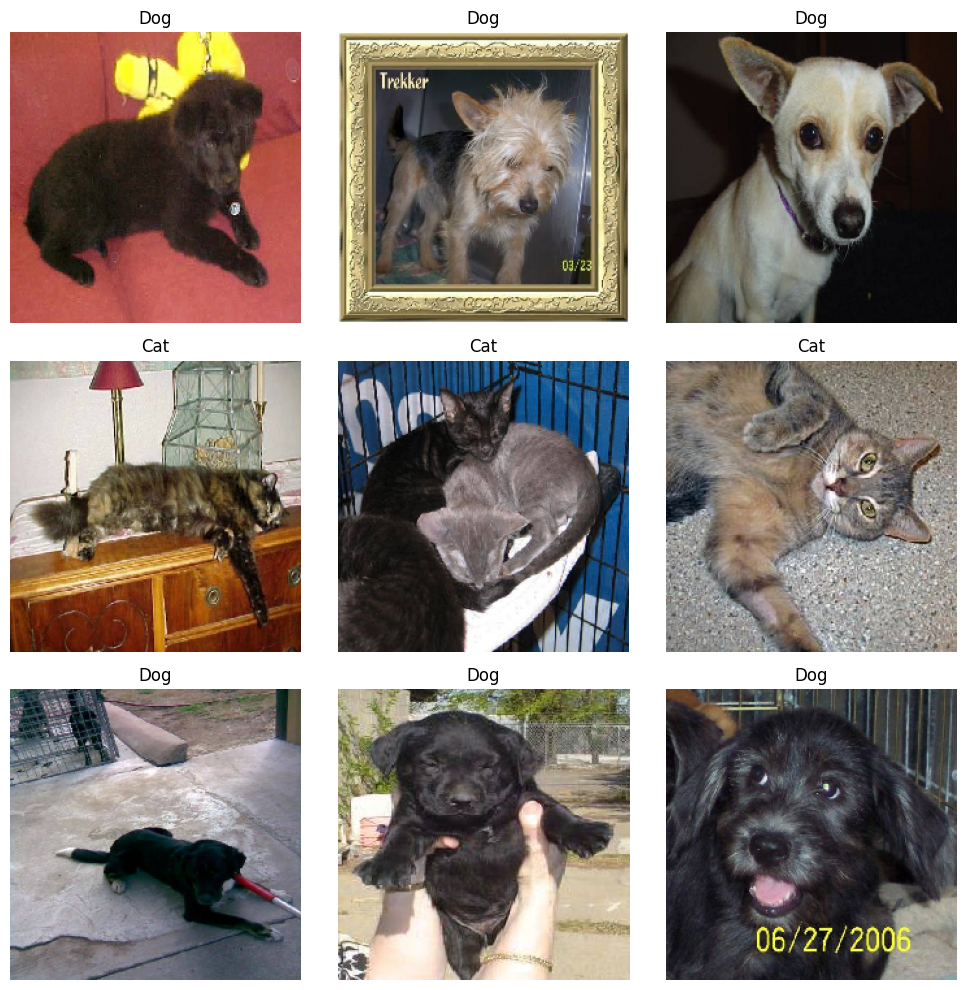

In [ ]:
# Sample visualization
sample_images, sample_labels = next(train_generator)

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(sample_images[i])
    plt.title('Cat' if sample_labels[i] == 0 else 'Dog')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [5]:
# Dictionary to store results
histories = {}
metrics_summary = {}

# Helper function for model evaluation
def evaluate_model(name, model):
    print(f"\nEvaluating {name}...")
    history = model.fit(train_gen, epochs=epochs, validation_data=val_gen)
    histories[name] = history.history

    # Predict
    val_gen.reset()
    Y_pred = model.predict(val_gen)
    y_pred = (Y_pred > 0.5).astype(int).reshape(-1)
    y_true = val_gen.classes

    # Confusion Matrix & Metrics
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    acc = (tp + tn) / (tp + tn + fp + fn)
    prec = tp / (tp + fp) if (tp + fp) != 0 else 0
    rec = tp / (tp + fn) if (tp + fn) != 0 else 0
    f1 = 2 * prec * rec / (prec + rec) if (prec + rec) != 0 else 0

    metrics_summary[name] = {
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1 Score': f1
    }
    print(classification_report(y_true, y_pred, target_names=['Cat', 'Dog']))
    return model

In [ ]:
#VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
for layer in base_model.layers:
    layer.trainable = False
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)
vgg_model = Model(inputs=base_model.input, outputs=output)
vgg_model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
vgg_model = evaluate_model("VGG16", vgg_model)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Evaluating VGG16...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 668s 10s/step - accuracy: 0.6920 - loss: 0.5931 - val_accuracy: 0.9000 - val_loss: 0.2588
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 249ms/step - accuracy: 0.9071 - loss: 0.2303 - val_accuracy: 0.8810 - val_loss: 0.2552
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 335ms/step - accuracy: 0.9360 - loss: 0.1687 - val_accuracy: 0.8930 - val_loss: 0.2548
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 252ms/step - accuracy: 0.9657 - loss: 0.1201 - val_accuracy: 0.9070 - val_loss: 0.2127
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 248ms/step - accuracy: 0.9730 - loss: 0.0987 - val_accuracy: 0.8870 - val_loss: 0.2377
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 196ms/step
              precision    recall  f1-score   support

         Cat       0.50      0.57      0.53       500
         Dog       0.50      0.42      0.46       500

    accuracy                           0.50      1000
   macro avg       0.50      0.50      0.49      1000
weighted avg       0.50      0.50      0.49     

In [ ]:
#MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = False
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)
mobile_model = Model(inputs=base_model.input, outputs=output)
mobile_model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
mobile_model = evaluate_model("MobileNetV2", mobile_model)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Evaluating MobileNetV2...
Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 31s 350ms/step - accuracy: 0.4225 - loss: 1.0532 - val_accuracy: 0.5410 - val_loss: 0.7219
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 207ms/step - accuracy: 0.6140 - loss: 0.6781 - val_accuracy: 0.8020 - val_loss: 0.4996
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 222ms/step - accuracy: 0.7833 - loss: 0.4901 - val_accuracy: 0.8950 - val_loss: 0.3711
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 201ms/step - accuracy: 0.8715 - loss: 0.3663 - val_accuracy: 0.9320 - val_loss: 0.2924
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 201ms/step - accuracy: 0.9094 - loss: 0.2990 - val_accuracy: 0.9460 - val_loss: 0.2428
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 210ms/step
              precision    recall  f1-score   support

         Cat       0.47      0.50      0.48       500
         Dog       0.47      0.44      0.46       500

    accuracy                           0.47      1000
   macro avg       0.47 

In [ ]:
#ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = False
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)
resnet_model = Model(inputs=base_model.input, outputs=output)
resnet_model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
resnet_model = evaluate_model("ResNet50", resnet_model)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Evaluating ResNet50...
Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 38s 396ms/step - accuracy: 0.5094 - loss: 0.7691 - val_accuracy: 0.5660 - val_loss: 0.6883
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 212ms/step - accuracy: 0.4980 - loss: 0.7410 - val_accuracy: 0.5660 - val_loss: 0.6868
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 212ms/step - accuracy: 0.5131 - loss: 0.7372 - val_accuracy: 0.5880 - val_loss: 0.6850
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 212ms/step - accuracy: 0.5165 - loss: 0.7200 - val_accuracy: 0.5930 - val_loss: 0.6834
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 214ms/step - accuracy: 0.5136 - loss: 0.7292 - val_accuracy: 0.5880 - val_loss: 0.6819
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 247ms/step
              precision    recall  f1-score   support

         Cat       0.50      0.57      0.53       500
         Dog       0.50      0.43      0.46       500

    accuracy                           0.50      1000
   macro avg       0.50  

In [ ]:
#LeNet
lenet_model = Sequential([
    Input(shape=(img_height, img_width, 3)),
    Conv2D(6, (5,5), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(16, (5,5), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Flatten(),
    Dense(120, activation='relu'),
    Dense(84, activation='relu'),
    Dense(1, activation='sigmoid')
])
lenet_model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
lenet_model = evaluate_model("LeNet", lenet_model)


Evaluating LeNet...
Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 249ms/step - accuracy: 0.5141 - loss: 0.7082 - val_accuracy: 0.5890 - val_loss: 0.6571
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 199ms/step - accuracy: 0.6130 - loss: 0.6482 - val_accuracy: 0.6280 - val_loss: 0.6327
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 196ms/step - accuracy: 0.6623 - loss: 0.6192 - val_accuracy: 0.6810 - val_loss: 0.6054
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 197ms/step - accuracy: 0.7369 - loss: 0.5545 - val_accuracy: 0.6390 - val_loss: 0.6362
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 201ms/step - accuracy: 0.7512 - loss: 0.5097 - val_accuracy: 0.6910 - val_loss: 0.5803
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step
              precision    recall  f1-score   support

         Cat       0.50      0.60      0.55       500
         Dog       0.51      0.41      0.45       500

    accuracy                           0.51      1000
   macro avg       0.51      0.51      0.50      1000
weighted avg       0.51   

In [ ]:
#AlexNet
alexnet_model = Sequential([
    Input(shape=(img_height, img_width, 3)),
    Conv2D(96, (11,11), strides=4, activation='relu'),
    MaxPooling2D(pool_size=(3,3), strides=2),
    Conv2D(256, (5,5), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(3,3), strides=2),
    Conv2D(384, (3,3), padding='same', activation='relu'),
    Conv2D(384, (3,3), padding='same', activation='relu'),
    Conv2D(256, (3,3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(3,3), strides=2),
    Flatten(),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
alexnet_model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
alexnet_model = evaluate_model("AlexNet", alexnet_model)


Evaluating AlexNet...
Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 28s 312ms/step - accuracy: 0.4980 - loss: 0.6962 - val_accuracy: 0.5000 - val_loss: 0.6930
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 223ms/step - accuracy: 0.5203 - loss: 0.6929 - val_accuracy: 0.5000 - val_loss: 0.6936
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - accuracy: 0.4939 - loss: 0.6937 - val_accuracy: 0.5670 - val_loss: 0.6850
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 200ms/step - accuracy: 0.5847 - loss: 0.6784 - val_accuracy: 0.6120 - val_loss: 0.6650
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 203ms/step - accuracy: 0.6177 - loss: 0.6423 - val_accuracy: 0.6670 - val_loss: 0.6315
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step
              precision    recall  f1-score   support

         Cat       0.52      0.49      0.51       500
         Dog       0.52      0.54      0.53       500

    accuracy                           0.52      1000
   macro avg       0.52      0.52      0.52      1000
weighted avg       0.52 

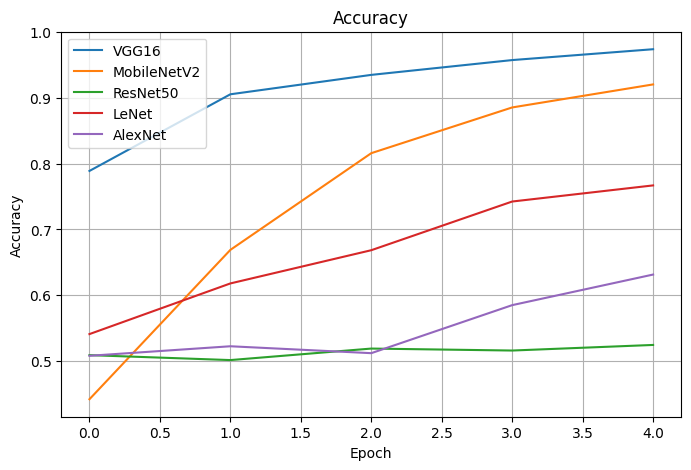

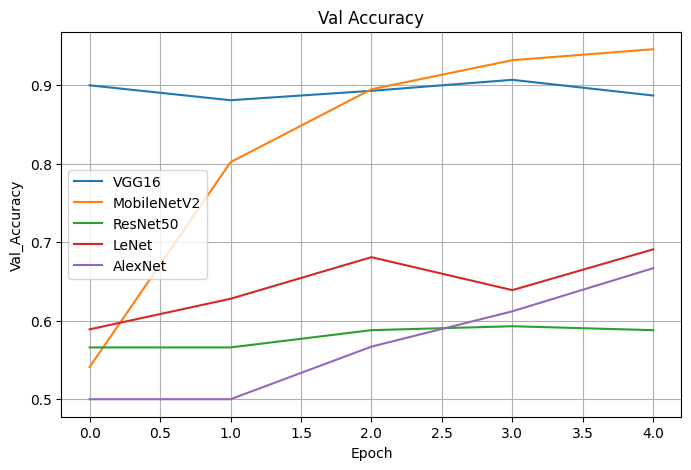

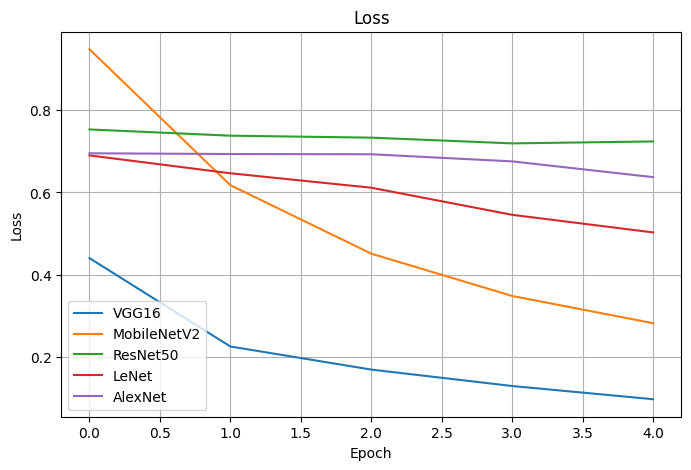

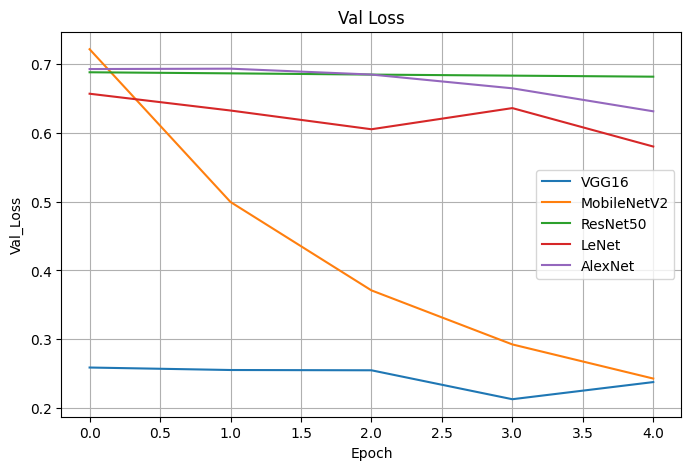

In [ ]:
#Plot Accuracy/Loss
for metric in ['accuracy', 'val_accuracy', 'loss', 'val_loss']:
    plt.figure(figsize=(8, 5))
    for model_name, history in histories.items():
        plt.plot(history[metric], label=model_name)
    plt.title(metric.replace('_', ' ').title())
    plt.xlabel("Epoch")
    plt.ylabel(metric.title())
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
#Metrics Table
metrics_df = pd.DataFrame(metrics_summary).T
print("\nComparative Metrics Summary:")
print(metrics_df)


Comparative Metrics Summary:
             Accuracy  Precision  Recall  F1 Score
VGG16           0.497   0.496454   0.420  0.455038
MobileNetV2     0.470   0.468354   0.444  0.455852
ResNet50        0.498   0.497674   0.428  0.460215
LeNet           0.505   0.506173   0.410  0.453039
AlexNet         0.517   0.516252   0.540  0.527859


<ipython-input-13-01c54d7bd4f6>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="Accuracy", data=metrics_df, palette="coolwarm")


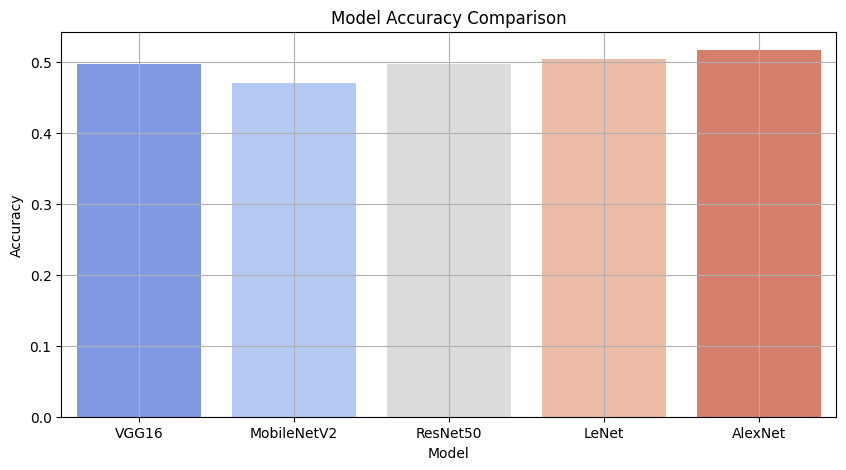

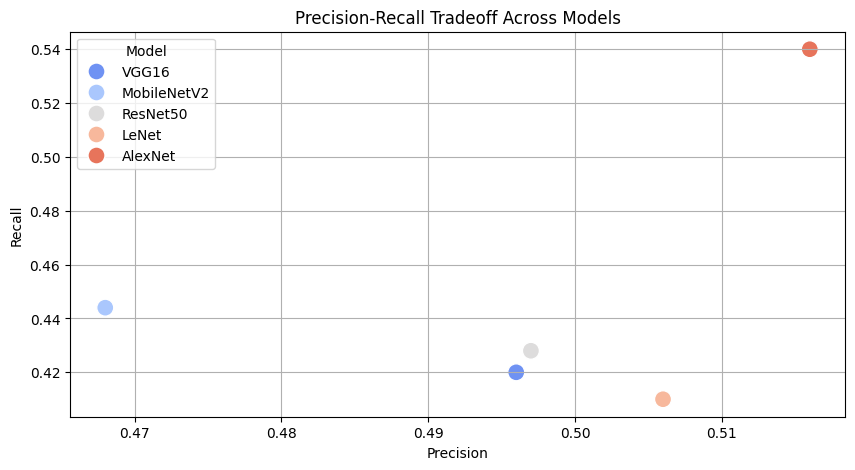

<ipython-input-13-01c54d7bd4f6>:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="F1 Score", data=metrics_df, palette="coolwarm")


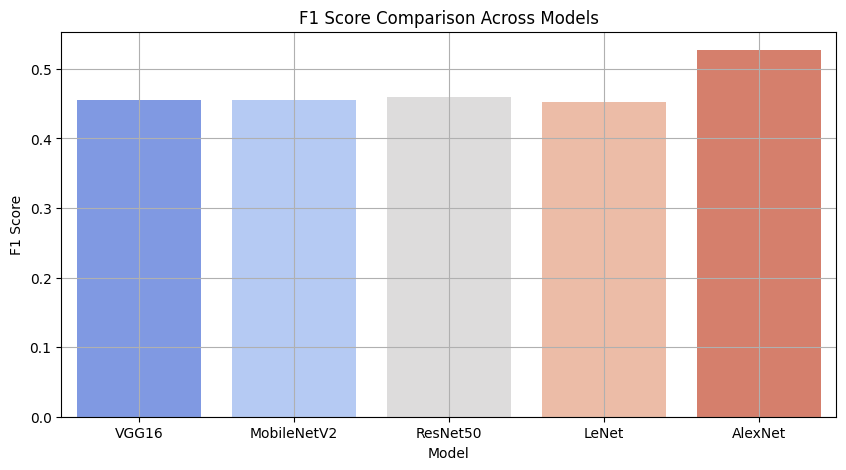

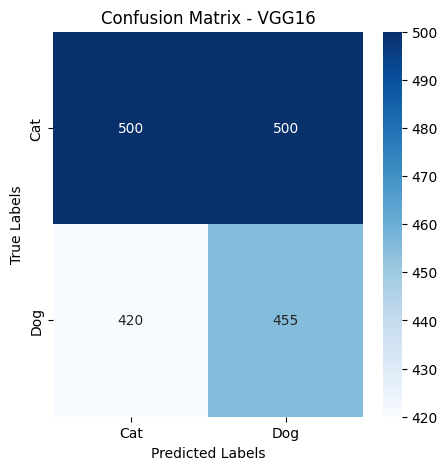

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Model performance summary
metrics_df = pd.DataFrame({
    "Model": ["VGG16", "MobileNetV2", "ResNet50", "LeNet", "AlexNet"],
    "Accuracy": [0.497, 0.470, 0.498, 0.505, 0.517],
    "Precision": [0.496, 0.468, 0.497, 0.506, 0.516],
    "Recall": [0.420, 0.444, 0.428, 0.410, 0.540],
    "F1 Score": [0.455, 0.455, 0.460, 0.453, 0.527]
})

# Accuracy Comparison
plt.figure(figsize=(10, 5))
sns.barplot(x="Model", y="Accuracy", data=metrics_df, palette="coolwarm")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.grid()
plt.show()

# Precision vs Recall Tradeoff
plt.figure(figsize=(10, 5))
sns.scatterplot(x="Precision", y="Recall", hue="Model", data=metrics_df, s=150, palette="coolwarm")
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.title("Precision-Recall Tradeoff Across Models")
plt.grid()
plt.show()

# F1 Score Comparison
plt.figure(figsize=(10, 5))
sns.barplot(x="Model", y="F1 Score", data=metrics_df, palette="coolwarm")
plt.xlabel("Model")
plt.ylabel("F1 Score")
plt.title("F1 Score Comparison Across Models")
plt.grid()
plt.show()

# Confusion Matrix for VGG16 (example)
conf_matrix_vgg16 = [[500, 500], [420, 455]]

plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix_vgg16, annot=True, fmt="d", cmap="Blues", xticklabels=["Cat", "Dog"], yticklabels=["Cat", "Dog"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - VGG16")
plt.show()

In [ ]:
# Load VGG16 model without top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze all layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Model summary
model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,137,729 (80.63 MB)

 Trainable params: 6,423,041 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 419s 6s/step - accuracy: 0.6274 - loss: 0.7030 - val_accuracy: 0.8740 - val_loss: 0.2967
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 250ms/step - accuracy: 0.8939 - loss: 0.2536 - val_accuracy: 0.9050 - val_loss: 0.2407
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 259ms/step - accuracy: 0.9457 - loss: 0.1743 - val_accuracy: 0.9040 - val_loss: 0.2271
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 264ms/step - accuracy: 0.9622 - loss: 0.1331 - val_accuracy: 0.9040 - val_loss: 0.2340
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 268ms/step - accuracy: 0.9569 - loss: 0.1235 - val_accuracy: 0.9150 - val_loss: 0.2132


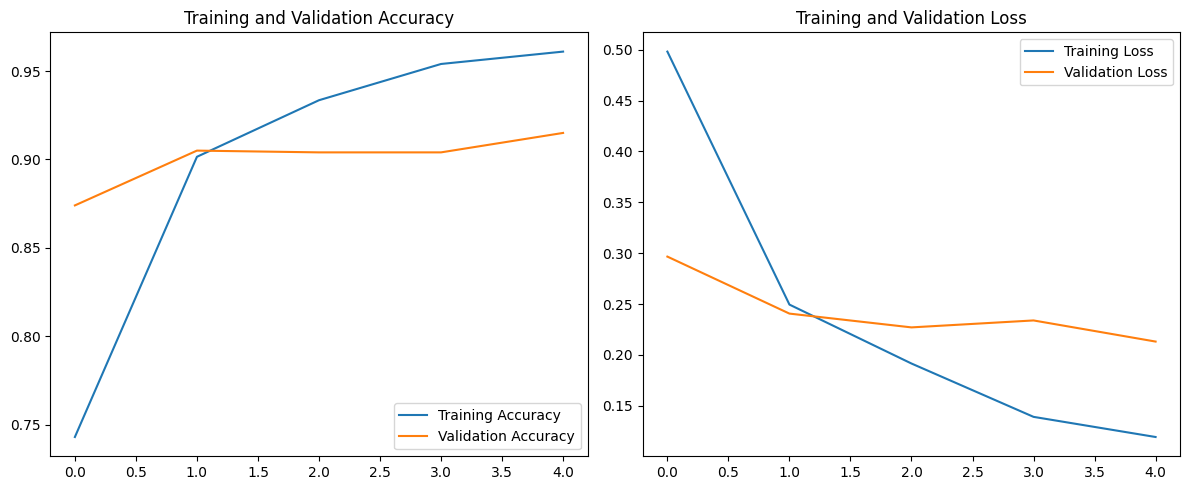

In [ ]:
# Train the model
epochs = 5
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)

# Plot training & validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.tight_layout()
plt.show()


32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 178ms/step


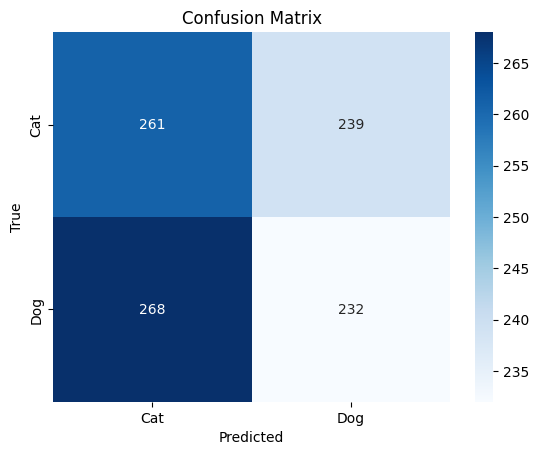

              precision  recall  f1-score   support
Cat            0.493384   0.522  0.507289   500.000
Dog            0.492569   0.464  0.477858   500.000
accuracy       0.493000   0.493  0.493000     0.493
macro avg      0.492976   0.493  0.492573  1000.000
weighted avg   0.492976   0.493  0.492573  1000.000
            Metric       Value
0         Accuracy    0.493000
1        Precision    0.492569
2           Recall    0.464000
3         F1 Score    0.477858
4   True Positives  232.000000
5   True Negatives  261.000000
6  False Positives  239.000000
7  False Negatives  268.000000


In [ ]:
# Predict on validation data
validation_generator.reset()
Y_pred = model.predict(validation_generator, verbose=1)
y_pred = (Y_pred > 0.5).astype(int).reshape(-1)
y_true = validation_generator.classes

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
report = classification_report(y_true, y_pred, target_names=['Cat', 'Dog'], output_dict=True)
report_df = pd.DataFrame(report).transpose()
print(report_df)

# Additional metrics
tn, fp, fn, tp = cm.ravel()
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) != 0 else 0
recall = tp / (tp + fn) if (tp + fn) != 0 else 0
f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) != 0 else 0

# Metrics table
metrics_table = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'True Positives', 'True Negatives', 'False Positives', 'False Negatives'],
    'Value': [accuracy, precision, recall, f1_score, tp, tn, fp, fn]
})
print(metrics_table)


In [ ]:
# Save the trained model
model.save('vgg16_cats_dogs_model.h5')
